Calculo del atlas 3 importando el atlas 2 y las imagenes originales

In [ ]:
pip install voxelmorph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import voxelmorph as vxm

In [ ]:
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5

--2023-04-23 17:43:58--  https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1323288 (1.3M)
Saving to: ‘vxm_dense_brain_T1_3D_mse.h5’

vxm_dense_brain_T1_ 100%[===================>]   1.26M  7.36MB/s    in 0.2s    

2023-04-23 17:43:59 (7.36 MB/s) - ‘vxm_dense_brain_T1_3D_mse.h5’ saved [1323288/1323288]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf

Cargamos las imagenes originales

In [ ]:
ruta_carpeta = '/content/drive/MyDrive/tfg/imagenesCN/'

lista_imagenes = os.listdir(ruta_carpeta)

sumaImagenes = np.zeros((1,176,208,176,1))

for nombre_imagen in lista_imagenes:
  ruta = ruta_carpeta + nombre_imagen
  print(ruta)
  imagen = nib.load(ruta).get_fdata()
  imagen = imagen[0:176,0:208,0:176]
  imagen = imagen[..., np.newaxis]
  imagen = imagen[np.newaxis, ...]
  imagen = (imagen - np.min(imagen)) / (np.max(imagen) - np.min(imagen))
  imagen.shape
  sumaImagenes = sumaImagenes + imagen

/content/drive/MyDrive/tfg/imagenesCN/002_S_0295_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_0685_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_0413_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_0559_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_1261_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_0907_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_1280_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_0931_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_0981_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_1021_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/005_S_0602_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/005_S_0223_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/005_S_0553_ADNI1_MPRAGE_N3-NoSkull.nii

Cargamos el atlas 2

In [ ]:
atlas_dos = np.load('/content/drive/MyDrive/tfg/atlas2.npy')

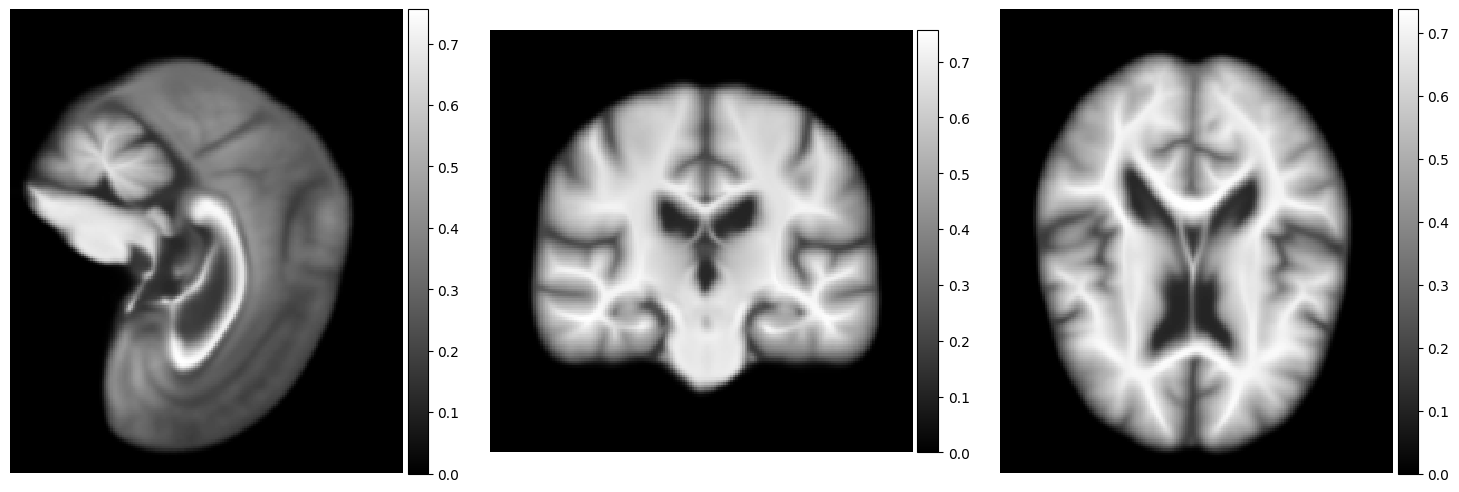

In [ ]:
import neurite as ne

vol_shape = (176, 208, 176)

mid_slices_atlas_dos_mostrar = [np.take(atlas_dos, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_atlas_dos_mostrar[1] = np.rot90(mid_slices_atlas_dos_mostrar[1], 1)
mid_slices_atlas_dos_mostrar[2] = np.rot90(mid_slices_atlas_dos_mostrar[2], -1)

ne.plot.slices(mid_slices_atlas_dos_mostrar, cmaps=['gray'], do_colorbars=True);

In [ ]:
atlas_dos = atlas_dos[..., np.newaxis]
atlas_dos = atlas_dos[np.newaxis, ...]

Calculamos la deformación y la imagen moved de las imagenes originales con el atlas 2

In [ ]:
inshape = atlas_dos.shape[1:-1]
nb_feats = atlas_dos.shape[-1]

print(inshape)
print(nb_feats)

gpu = 0
device, nb_devices = vxm.tf.utils.setup_device(gpu)

array_result = np.zeros((1,176,208,176,1))

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    model = vxm.networks.VxmDense.load('vxm_dense_brain_T1_3D_mse.h5', **config)

    for nombre_imagen in lista_imagenes:
      ruta = ruta_carpeta + nombre_imagen
      print(ruta)
      imagen = nib.load(ruta).get_fdata()
      imagen = imagen[0:176,0:208,0:176]
      imagen = imagen[..., np.newaxis]
      imagen = imagen[np.newaxis, ...]
      imagen = (imagen - np.min(imagen)) / (np.max(imagen) - np.min(imagen))
      imagen.shape
      val_pred = model.predict([imagen, atlas_dos])
      array_result = array_result + val_pred[0]

(176, 208, 176)
1


/usr/local/lib/python3.9/dist-packages/voxelmorph/tf/networks.py:124: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
/usr/local/lib/python3.9/dist-packages/voxelmorph/tf/networks.py:129: UserWarning: unet_half_res is deprecated, use the svf_resolution parameter.
  warnings.warn('unet_half_res is deprecated, use the svf_resolution parameter.')


/content/drive/MyDrive/tfg/imagenesCN/002_S_0295_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 15s 15s/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_0685_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 1s 866ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_0413_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 1s 569ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_0559_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 498ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_1261_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 487ms/step
/content/drive/MyDrive/tfg/imagenesCN/003_S_0907_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 499ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_1280_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 497ms/step
/content/drive/MyDrive/tfg/imagenesCN/003_S_0931_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [=========

Calculamos el atlas 3 haciendo la media de las imagenes moved

In [ ]:
atlas_tres = array_result/len(lista_imagenes)
atlas_tres.shape

(1, 176, 208, 176, 1)

In [ ]:
atlas_tres_mostrar = atlas_tres.squeeze()

MOSTRAMOS ALTAS 3

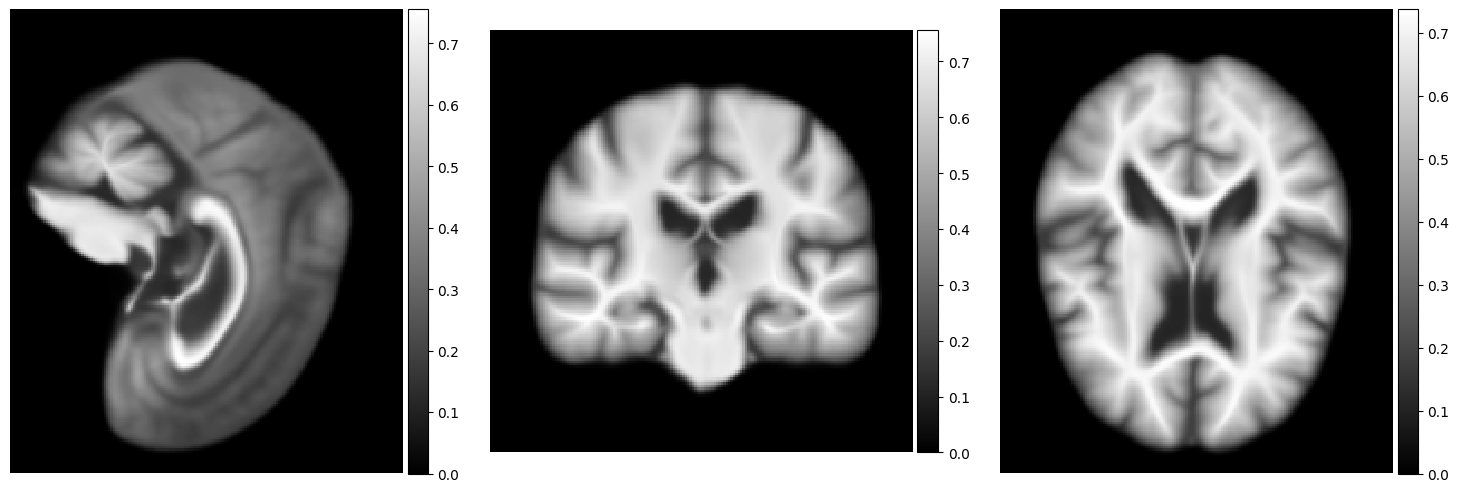

In [ ]:
mid_slices_atlas_tres_mostrar = [np.take(atlas_tres_mostrar, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_atlas_tres_mostrar[1] = np.rot90(mid_slices_atlas_tres_mostrar[1], 1)
mid_slices_atlas_tres_mostrar[2] = np.rot90(mid_slices_atlas_tres_mostrar[2], -1)

ne.plot.slices(mid_slices_atlas_tres_mostrar, cmaps=['gray'], do_colorbars=True);

Guardamos en drive el atlas 3

In [ ]:
np.save('/content/drive/MyDrive/tfg/atlas3.npy', atlas_tres_mostrar)